In [77]:
import jax.numpy as jnp
import jax
import os
import pickle
import math
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.70'

jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_platform_name", "cpu")

os.chdir('/home/zongchen/chard/')

import matplotlib.pyplot as plt

from kwgflows.rkhs.kernels import *
import ot
from kwgflows.divergences.mmd import *
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 22
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=22)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=22, frameon=False)
plt.rc('xtick', labelsize=18, direction='in')
plt.rc('ytick', labelsize=18, direction='in')
plt.rc('figure', figsize=(6, 4))


<Figure size 600x400 with 0 Axes>

In [78]:
nystrom_list = [0, 50, 150, 200]
chard_trajectory = {0.1: None,
                    0.01: None,
                    0.001: None}
chard_config = {0.1: None,
                    0.01: None,
                    0.001: None}
lambda_list = [0.1, 0.01, 0.001]

chard_dir = '/home/zongchen/chard/results_rebuttal/ThreeRing_dataset/Gaussian_kernel/chard_flow/'

for l in lambda_list:
    chard_hyper = [f'lmbda_{l}_', 
                'bandwidth_0.15_',
                'step_num_10000_',
                'source_particle_num_300_',
                'inject_noise_scale_0.0_',
                'opt_sgd_']
    chard_trajectory[l] = {e: None for e in nystrom_list}
    chard_config[l] = {e: None for e in nystrom_list}
    
    for file in os.listdir(chard_dir):
        if all(hyper in file for hyper in chard_hyper):
            for nystrom in nystrom_list:
                if f'nystrom_{nystrom}_' in file:
                    chard_trajectory[l][nystrom] = jnp.load(chard_dir + file + '/Ys.npy')
                    chard_config[l][nystrom] = pickle.load(open(chard_dir + file + '/configs', 'rb'))
                    
    if chard_trajectory[l][nystrom] is None:
        print(f'No chard trajectory found for {l} {nystrom}')
        raise ValueError('No chard trajectory found')



In [79]:
import argparse
args_dict = {0.1: None,
                    0.01: None,
                    0.001: None}

for l in lambda_list:
    args_dict[l] = {e: None for e in nystrom_list}

    for nystrom in nystrom_list:
        # Create the ArgumentParser object
        parser = argparse.ArgumentParser(description='Convert dictionary to parser arguments')

        # Add arguments to the parser based on the dictionary
        for key, value in chard_config[l][nystrom].items():
            # Determine the type of the value for proper handling
            if isinstance(value, int):
                parser.add_argument(f'--{key}', type=int, default=value, help=f'{key} (default: {value})')
            else:
                parser.add_argument(f'--{key}', type=str, default=value, help=f'{key} (default: "{value}")')

        # Parse command line arguments (this line is for demonstration and typically uses sys.argv)
        args_dict[l][nystrom] = parser.parse_args([])  # Empty list simulates no command-line arguments




In [80]:
args_dict[l][nystrom]

Namespace(seed=43, dataset='ThreeRing', flow='chard', kernel='Gaussian', spectral='tikhonov', lmbda=0.001, step_size=0.0001, nystrom=200, save_path='./results_rebuttal/ThreeRing_dataset/Gaussian_kernel/chard_flow/__lmbda_0.001__step_size_0.0001__bandwidth_0.15__step_num_10000__source_particle_num_300__inject_noise_scale_0.0__nystrom_200__logccv_1.0__opt_sgd__seed_43', bandwidth=0.15, step_num=10000, source_particle_num=300, target_particle_num=300, diffusion_noise_scale=1.0, inject_noise_scale=0.0, logccv=1.0, opt='sgd')

In [81]:

def compute_wasserstein_distance_numpy(X, Y):
    a, b = jnp.ones((X.shape[0], )) / X.shape[0], jnp.ones((Y.shape[0], )) / Y.shape[0]
    M = ot.dist(X, Y, 'euclidean')
    W = ot.emd(a, b, M)
    Wd = (W * M).sum()
    return Wd

def compute_wasserstein_distance_trajectory(flow_1, flow_2, eval_freq):
    assert flow_1.shape[0] == flow_2.shape[0]
    T = flow_1.shape[0]
    wasserstein_distance = []
    for i in range(0, T, eval_freq):
        wasserstein_distance.append(compute_wasserstein_distance_numpy(flow_1[i, :], flow_2[i, :]))
    wasserstein_distance = jnp.array(wasserstein_distance)
    return wasserstein_distance

def compute_all_distance_trajectory(args, trajectory, target, kernel):
    mmd_divergence = mmd_fixed_target(args, kernel, None)
    mmd_divergence.pre_compute(target)
    mmd_distance = jax.vmap(mmd_divergence)(trajectory)

    chard_divergence = chard_fixed_target(args, kernel, None)
    chard_divergence.pre_compute(target)
    chard_distance = jax.vmap(chard_divergence)(trajectory)

    T = trajectory.shape[0]
    wass_distance = compute_wasserstein_distance_trajectory(trajectory, jnp.repeat(target[None, :], T, axis=0), eval_freq=1)
    return mmd_distance, chard_distance, wass_distance

In [82]:
def generate_three_ring_and_gaussian(Nx, Ny):
    rng_key = jax.random.PRNGKey(40)
    r, _delta = 0.3, 0.5
    
    X = jnp.c_[r * jnp.cos(jnp.linspace(0, 2 * jnp.pi, Nx + 1)), r * jnp.sin(jnp.linspace(0, 2 * jnp.pi, Nx + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = jnp.r_[X, X[:Nx, :]-i*jnp.array([0, (2 + _delta) * r])]

    rng_key, _ = jax.random.split(rng_key)
    Y = jax.random.normal(rng_key, (Ny, 2)) / 100 - jnp.array([0, r])
    return X, Y

In [83]:
chard_trajectory[0.1].keys()

dict_keys([0, 50, 150, 200])

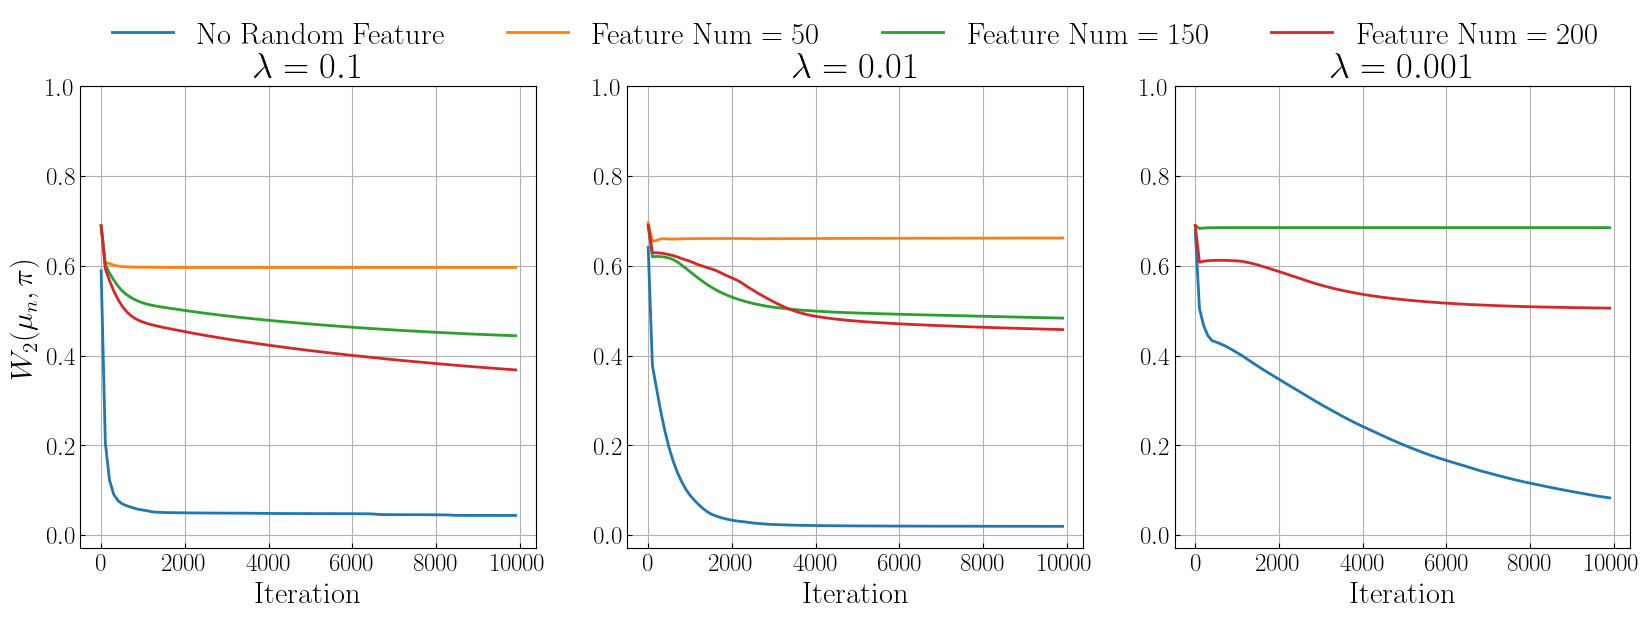

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for j, l in enumerate(lambda_list):

    for i, (nystrom, trajectory) in enumerate(chard_trajectory[l].items()):
        T = trajectory.shape[0]
        x_ticks = jnp.arange(0, 100* T, 100)

        particle_num = trajectory.shape[1]

        target, _ = generate_three_ring_and_gaussian(int(particle_num/3), particle_num)
        kernel = gaussian_kernel(chard_config[l][nystrom]['bandwidth'])
        mmd, chard, wass = compute_all_distance_trajectory(args_dict[l][nystrom], trajectory, target, kernel)
        if nystrom == 0:
            axs[j].plot(x_ticks, wass, label=rf'No Random Feature')
        else:
            axs[j].plot(x_ticks, wass, label=rf'Feature Num $={nystrom}$')
        axs[j].set_title(rf'$\lambda = {l}$')
        axs[j].set_xlabel('Iteration')
        axs[j].set_ylim([-0.03, 1.0])

axs[0].set_ylabel(r'$W_2(\mu_n, \pi)$')
axs[1].legend(ncol=4, bbox_to_anchor=(0.5, 1.2), loc='upper center')
# plt.tight_layout()
plt.savefig('./figures/nystrom.pdf')
plt.show()